### Dự đoán trạng thái, lỗi sai của động tác Lunge

In [1]:
# Thêm autoreload vào để tự động reload lại module nếu có thay đổi code trong module
%load_ext autoreload
%autoreload 2

import mediapipe as mp
import numpy as np
import pandas as pd
import cv2
import warnings
warnings.filterwarnings('ignore')

import os, sys
sys.path.append(os.path.abspath(".."))
from utils.common import load_model

# Drawing helpers
mp_drawing = mp.solutions.drawing_utils
mp_pose = mp.solutions.pose

### Thực hiện việc dự đoán với các model Scikit learn có độ chính xác cao nhất

In [2]:
# Load model
RF_model = load_model('./best_models/RF_model.pkl')
XGB_model = load_model('./best_models/XGB.pkl')

RF_model.set_params(verbose=0)
XGB_model.set_params(verbose=0)

# Load input scaler
input_scaler = load_model("./best_models/input_scaler.pkl")

### Các landmarks quan trọng
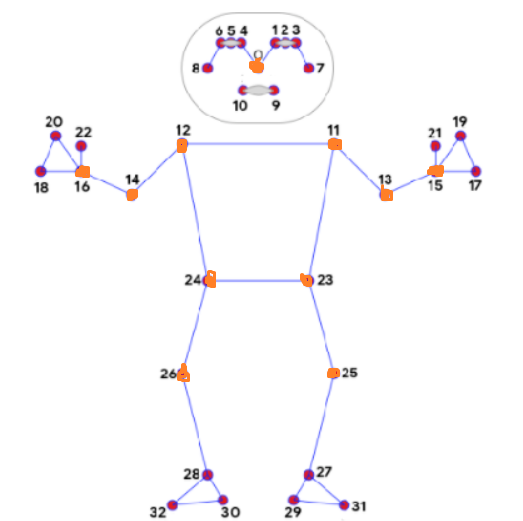

In [3]:
IMPORTANT_LMS = [
    "NOSE",
    "LEFT_SHOULDER",
    "RIGHT_SHOULDER",
    "LEFT_ELBOW",
    "RIGHT_ELBOW",
    "LEFT_WRIST",
    "RIGHT_WRIST",
    "LEFT_HIP",
    "RIGHT_HIP",
]

# Tạo các cột cho dữ liệu đầu vào
HEADERS = ["label"]
for landmark in IMPORTANT_LMS:
    for dim in ['x', 'y', 'z']:
        HEADERS.append(f"{landmark.lower()}_{dim}")

In [4]:
import os
import soundfile as sf

# Khởi tạo dictionary để lưu các đối tượng audio
error_types_audio = {}

# Thư mục chứa các file âm thanh
folder_path = "audios"
current_path = os.getcwd()

# Duyệt qua các file trong thư mục
for filename in os.listdir(folder_path):
    file_path = os.path.join(current_path, folder_path, filename)
    if os.path.isfile(file_path):
        data, samplerate = sf.read(file_path)
        filename = filename.replace(".wav", "")
        error_types_audio[filename] = (data, samplerate)

In [5]:
def extract_and_recalculate_landmarks(pose_landmarks):
    """
    Tịnh tiến thân người vào giữa bức hình, đồng thời dời lại trục toạ độ
    """
    hip_center_x = float((pose_landmarks[23].x + pose_landmarks[24].x) / 2)
    hip_center_y = float((pose_landmarks[23].y + pose_landmarks[24].y) / 2)

    new_center = (0.5, 0.5)
    delta_x = new_center[0] - hip_center_x
    delta_y = new_center[1] - hip_center_y

    # Khởi tạo mảng NumPy với kích thước đã biết trước
    data = np.zeros((len(IMPORTANT_LMS), 3))

    for idx, landmark in enumerate(IMPORTANT_LMS):
        key_point_id = mp_pose.PoseLandmark[landmark].value
        key_point = pose_landmarks[key_point_id]
        data[idx] = [key_point.x + delta_x - 0.5, key_point.y + delta_y - 0.5, key_point.z]

    return data.flatten().tolist()

def rescale_frame(frame, percent=50):
    '''
    Rescale a frame to a certain percentage compare to its original frame
    '''
    width = int(frame.shape[1] * percent/ 100)
    height = int(frame.shape[0] * percent/ 100)
    dim = (width, height)
    return cv2.resize(frame, dim, interpolation =cv2.INTER_AREA)

In [6]:
def angle_2_vector(v1, v2):
    """
    Tính góc giữa 2 vector
    """
    dot = np.dot(v1, v2)
    norm_v1 = np.linalg.norm(v1)
    norm_v2 = np.linalg.norm(v2)
    cos_theta = dot / (norm_v1 * norm_v2)

    return np.arccos(cos_theta) * 180 / np.pi

In [7]:
def get_class(encode_label: float):
    """
    Chuyển một label được encode thành class tương ứng
    """
    return {
        0: "Down",
        1: "Middle",
        2: "Up"
    }.get(encode_label)

### Dùng phương pháp hình học để xác định lỗi sai

In [8]:
import math
def calculate_angle(a, b, c, size_of_image):
    # Lấy tọa độ của 3 điểm
    a = (a[0] * size_of_image[0], a[1] * size_of_image[1])
    b = (b[0] * size_of_image[0], b[1] * size_of_image[1])
    c = (c[0] * size_of_image[0], c[1] * size_of_image[1])

    # Tính góc giữa 3 điểm
    ba_vector = [a[0] - b[0], a[1] - b[1]]
    bc_vector = [c[0] - b[0], c[1] - b[1]]
    ba_length = math.sqrt(ba_vector[0] ** 2 + ba_vector[1] ** 2)
    bc_length = math.sqrt(bc_vector[0] ** 2 + bc_vector[1] ** 2)

    return math.degrees(math.acos((ba_vector[0] * bc_vector[0] + ba_vector[1] * bc_vector[1]) / (ba_length * bc_length)))    


In [18]:
def rescale_frame(frame, percent=50):
    """
    Rescale a frame to a certain percentage compare to its original frame
    """
    width = int(frame.shape[1] * percent / 100)
    height = int(frame.shape[0] * percent / 100)
    dim = (width, height)
    return cv2.resize(frame, dim, interpolation=cv2.INTER_AREA)


def get_image_size(image):
    return image.shape[1], image.shape[0]


def define_errors(key_points, image_size):
    errors = []
    left_shoulder = [key_points[11].x, key_points[11].y]
    right_shoulder = [key_points[12].x, key_points[12].y]
    left_hip = [key_points[23].x, key_points[23].y]
    right_hip = [key_points[24].x, key_points[24].y]
    left_elbow = [key_points[13].x, key_points[13].y]
    right_elbow = [key_points[14].x, key_points[14].y]
    left_wrist = [key_points[15].x, key_points[15].y]
    right_wrist = [key_points[16].x, key_points[16].y]
    left_index = [key_points[19].x, key_points[19].y]
    right_index = [key_points[20].x, key_points[20].y]

    # Góc giữa vector vai, hông và đầu gối
    left_body_angle = angle_2_vector(
        np.array(
            [
                (left_shoulder[0] - left_hip[0]) * image_size[0],
                (left_shoulder[1] - left_hip[1]) * image_size[1],
            ]
        ),
        np.array([1, 0]),
    )
    right_body_angle = angle_2_vector(
        np.array(
            [
                (right_shoulder[0] - right_hip[0]) * image_size[0],
                (right_shoulder[1] - right_hip[1]) * image_size[1],
            ]
        ),
        np.array([1, 0]),
    )
    angle = max(left_body_angle, right_body_angle)
    print("Body angle: ", angle)
    if angle < 80 or angle > 100:
        errors.append("body not straight")

    # Góc giữa vai, khuỷu tay và hông
    angle = calculate_angle(left_shoulder, left_hip, left_elbow, image_size)
    angle = max(
        angle, calculate_angle(right_shoulder, right_hip, right_elbow, image_size)
    )
    if angle > 25:
        errors.append("arm not straight")

    # Góc giữa khuỷu tay, cổ tay và ngón tay trỏ
    angle = calculate_angle(left_elbow, left_wrist, left_index, image_size)
    angle = 180 - max(
        angle, calculate_angle(right_elbow, right_wrist, right_index, image_size)
    )
    if angle >= 50:
        errors.append("wrist not straight")

    if errors == []:
        return "None"
    else:
        return ", ".join(errors)

In [10]:
def determine_stage(key_points, image_size):
    # Dựa vào góc giữa khuỷu tay, cổ tay và vai để xác định giai đoạn của động tác Bicep Curl
    left_shoulder = [key_points[11].x, key_points[11].y]
    right_shoulder = [key_points[12].x, key_points[12].y]
    left_elbow = [key_points[13].x, key_points[13].y]
    right_elbow = [key_points[14].x, key_points[14].y]
    left_wrist = [key_points[15].x, key_points[15].y]
    right_wrist = [key_points[16].x, key_points[16].y]

    # Tính góc giữa 2 vector
    left_angle = calculate_angle(left_shoulder, left_elbow, left_wrist, image_size)
    right_angle = calculate_angle(right_shoulder, right_elbow, right_wrist, image_size)
    
    if abs(left_angle - right_angle) < 10:
        angle = max(left_angle, right_angle)
    else:
        angle = min(left_angle, right_angle)
    print(left_angle, right_angle)

    if angle > 160:
        return "Down"
    elif angle > 90:
        return "Middle"
    else:
        return "Up"

### Detection

In [20]:
VIDEO_TEST = "./testing.mp4"

In [12]:
import threading
import sounddevice as sd

is_playing = False

def play_audio(data, samplerate):
    global is_playing
    is_playing = True
    sd.play(data, samplerate)
    sd.wait()
    is_playing = False

# Hàm bắt đầu một luồng để phát âm thanh
def start_audio_thread(data, samplerate):
    threading.Thread(target=play_audio, args=(data, samplerate,), daemon=True).start()

In [ ]:
import copy

cap = cv2.VideoCapture(VIDEO_TEST)
current_stage = "Unknown"
prediction_probability_threshold = 0.55

# Số frame được bỏ qua
frame_skip = 1
frame_count = 0

# Số rep tập được
counter = 0
direction = "Up"

with mp_pose.Pose(min_detection_confidence=0.5, min_tracking_confidence=0.5) as pose:
    while cap.isOpened():
        ret, image = cap.read()

        if not ret:
            print("Ignoring empty camera frame.")
            break
        
        frame_count += 1
        
        # Bỏ qua frame nếu không phải frame được xử lý
        if frame_count % frame_skip != 0:
            continue

        image = rescale_frame(image, percent=60)
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        results = pose.process(image)

        if not results.pose_landmarks:
            print("No human found")
            continue

        initial_pose_landmarks = copy.deepcopy(results.pose_landmarks)
        image.flags.writeable = True

        # Cần khôi phục lại màu gốc của ảnh
        image = cv2.cvtColor(image, cv2.COLOR_RGB2BGR)

        # Draw landmarks and connections
        mp_drawing.draw_landmarks(image, results.pose_landmarks, 
                                  mp_pose.POSE_CONNECTIONS, 
                                  mp_drawing.DrawingSpec(color=(244, 117, 66), thickness=2, circle_radius=2), 
                                  mp_drawing.DrawingSpec(color=(245, 66, 230), thickness=2, circle_radius=1))
        
        # Get landmarks
        try:
            errors = define_errors(results.pose_landmarks.landmark)
            key_points = extract_and_recalculate_landmarks(results.pose_landmarks.landmark)
            X = pd.DataFrame([key_points], columns=HEADERS[1:])
            X = input_scaler.transform(X)

            predicted_stage = RF_model.predict(X)[0]
            predicted_stage = get_class(predicted_stage)
            prediction_probability_max = RF_model.predict_proba(X)[0].max()

            errors_list = errors.split(", ")
            if len(errors_list) == 1:
                error_types = errors_list[0].replace(" ", "_")
            elif len(errors_list) == 2:
                error_types = "_".join(errors_list).replace(" ", "_").replace("_not_straight", "", 1)
            else:
                error_types = "_".join([errors_list[0], errors_list[1]]).replace(" ", "_").replace("_not_straight", "", 1)

            if errors != "None" and error_types in error_types_audio and not is_playing:
                start_audio_thread(*error_types_audio[error_types])

            if current_stage == "Up" and predicted_stage == "Middle":
                direction = "Down"
            elif current_stage == "Middle" and predicted_stage == "Down" and direction == "Down":
                counter += 1
                direction = "Up"
            current_stage = predicted_stage

            cv2.rectangle(image, (0, 0), (image.shape[1], 60), (245, 117, 16), -1)            
            cv2.putText(image, "STAGE, REP", (30, 20), cv2.FONT_HERSHEY_SIMPLEX, 0.5, (0, 0, 0), 1, cv2.LINE_AA)
            if predicted_stage == "Up":
                cv2.putText(image, f"{predicted_stage}, {counter}", (40, 45), cv2.FONT_HERSHEY_SIMPLEX, 0.8, 
                        (255, 255, 255), 2, cv2.LINE_AA)
            else:
                cv2.putText(image, f"{predicted_stage}, {counter}", (20, 45), cv2.FONT_HERSHEY_SIMPLEX, 0.8, 
                        (255, 255, 255), 2, cv2.LINE_AA)

            cv2.putText(image, "ERRORS", (220, 20), cv2.FONT_HERSHEY_SIMPLEX, 0.5, (0, 0, 0), 1, cv2.LINE_AA)

            # Hiển thị các lỗi theo hàng dọc
            y_position = 45
            for error in errors_list:
                cv2.putText(image, error, (220, y_position), cv2.FONT_HERSHEY_SIMPLEX, 0.6, (0, 150, 255), 2, cv2.LINE_AA)
                y_position += 30

        except Exception as e:
            print(f"Error: {e}")

        cv2.imshow("CV2", image)
        
        # Nhấn q để thoát
        if cv2.waitKey(1) & 0xFF == ord('q'):
            break
    cap.release()
    cv2.destroyAllWindows()

In [13]:
def detection_without_model():
    cap = cv2.VideoCapture(VIDEO_TEST)
    current_stage = "Unknown"

    # Số frame được bỏ qua
    frame_skip = 1
    frame_count = 0

    # Số rep tập được
    counter = 0
    direction = "Up"

    with mp_pose.Pose(min_detection_confidence=0.5, min_tracking_confidence=0.5) as pose:
        while cap.isOpened():
            ret, image = cap.read()

            if not ret:
                print("Ignoring empty camera frame.")
                break
            
            frame_count += 1
            
            # Bỏ qua frame nếu không phải frame được xử lý
            if frame_count % frame_skip != 0:
                continue

            image = rescale_frame(image, percent=60)
            image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
            results = pose.process(image)

            if not results.pose_landmarks:
                print("No human found")
                continue

            image.flags.writeable = True

            # Cần khôi phục lại màu gốc của ảnh
            image = cv2.cvtColor(image, cv2.COLOR_RGB2BGR)

            # Draw landmarks and connections
            mp_drawing.draw_landmarks(image, results.pose_landmarks, 
                                    mp_pose.POSE_CONNECTIONS, 
                                    mp_drawing.DrawingSpec(color=(244, 117, 66), thickness=2, circle_radius=2), 
                                    mp_drawing.DrawingSpec(color=(245, 66, 230), thickness=2, circle_radius=1))
            
            # Get landmarks
            try:
                image_size = get_image_size(image)
                errors = define_errors(results.pose_landmarks.landmark, image_size)
                predicted_stage = determine_stage(results.pose_landmarks.landmark, image_size)

                errors_list = errors.split(", ")
                if len(errors_list) == 1:
                    error_types = errors_list[0].replace(" ", "_")
                elif len(errors_list) == 2:
                    error_types = "_".join(errors_list).replace(" ", "_").replace("_not_straight", "", 1)
                else:
                    error_types = "_".join([errors_list[0], errors_list[1]]).replace(" ", "_").replace("_not_straight", "", 1)

                if errors != "None" and error_types in error_types_audio and not is_playing:
                    start_audio_thread(*error_types_audio[error_types])

                if current_stage == "Up" and predicted_stage == "Middle":
                    direction = "Down"
                elif current_stage == "Middle" and predicted_stage == "Down" and direction == "Down":
                    counter += 1
                    direction = "Up"
                current_stage = predicted_stage

                cv2.rectangle(image, (0, 0), (image.shape[1], 60), (245, 117, 16), -1)            
                cv2.putText(image, "STAGE, REP", (30, 20), cv2.FONT_HERSHEY_SIMPLEX, 0.5, (0, 0, 0), 1, cv2.LINE_AA)
                if predicted_stage == "Up":
                    cv2.putText(image, f"{predicted_stage}, {counter}", (40, 45), cv2.FONT_HERSHEY_SIMPLEX, 0.8, 
                            (255, 255, 255), 2, cv2.LINE_AA)
                else:
                    cv2.putText(image, f"{predicted_stage}, {counter}", (20, 45), cv2.FONT_HERSHEY_SIMPLEX, 0.8, 
                            (255, 255, 255), 2, cv2.LINE_AA)

                cv2.putText(image, "ERRORS", (220, 20), cv2.FONT_HERSHEY_SIMPLEX, 0.5, (0, 0, 0), 1, cv2.LINE_AA)

                # Hiển thị các lỗi theo hàng dọc
                y_position = 45
                for error in errors_list:
                    cv2.putText(image, error, (220, y_position), cv2.FONT_HERSHEY_SIMPLEX, 0.6, (0, 150, 255), 2, cv2.LINE_AA)
                    y_position += 30

            except Exception as e:
                print(f"Error: {e}")

            cv2.imshow("CV2", image)
            
            # Nhấn q để thoát
            if cv2.waitKey(1) & 0xFF == ord('q'):
                break
        cap.release()
        cv2.destroyAllWindows()

In [22]:
detection_without_model()

Body angle:  94.61937875312957
168.26873902818522 162.1337481730077
Body angle:  94.61693990675197
167.85613069365843 162.2029412805305
Body angle:  94.5790325801547
166.77903671533912 162.2129188123171
Body angle:  94.76521027137439
161.32155344073252 161.29244341237927
Body angle:  94.99308509986419
157.52181121918085 160.2158563072158
Body angle:  95.2276164044351
153.72811824858266 159.31591056940601
Body angle:  95.3353730221289
151.24408879035028 157.53103630722225
Body angle:  95.56955255248765
147.2352849506566 152.7877264445466
Body angle:  95.71093832251782
144.12491701662006 149.22270273318873
Body angle:  95.93678553189517
139.1581012595203 144.92695658354742
Body angle:  95.88396992325941
128.48173646692075 131.86652439985843
Body angle:  95.66237375780611
122.82924725296371 128.47771495827584
Body angle:  95.46064399227765
115.79370721823477 123.89847900629164
Body angle:  94.82933397532511
108.4702324644492 114.17804433281827
Body angle:  93.97127509661284
101.6931450726